In [7]:
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from scipy import stats

import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.formula.api as smf

from statsmodels.stats.multicomp import pairwise_tukeyhsd

import re
import nltk


from sklearn.feature_extraction.text import CountVectorizer

from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

from datetime import datetime

import xgboost as xgb

In [8]:
pd.set_option('display.max_rows', 10000)
pd.set_option('display.max_columns', 10000)

In [129]:
def clear():
    os.system('cls')

def ListNoDups(mylist):
    mylist = list(dict.fromkeys(mylist))
    return mylist

def CleanList(list_to_clean, len_less_than = 3):
    cleaned_list = [x for x in list_to_clean if str(x) != 'nan' and len(x) >= len_less_than ]
    return cleaned_list

def CombineTwoLists(list1, list2):
    #Combines two lists i.e. element 0 of list 1 to elemenet 0 of list 2 and creates a list so the output is a list of lists
    
    if type(list2) != list or type(list1) != list:
        print('At least one argument is not a list')
        return        
    
    if len(list1) != len(list2):
        print('Lists have different lengths')
        return
    
    final_list = []
    
    for index, (element1, element2)  in enumerate(zip(list1, list2)):
        list_to_append = [element1, element2]
        final_list.append(list_to_append)
    
    final_list = final_list[0:]
    return final_list

class CarData:
    
    missing = -1
    duplicates = -1
    
    price_outliers = -1
    mileage_outliers = -1
    year_outliers = -1
    total_discard = -1
    
    corpus = []
    def __init__(self, path, price_outlier_mt = 200000, mileage_outlier_mt = 400000,
                year_outlier_lt = 1995, engine_outlier_mt = 4000, engine_outlier_lt = 750,
                dependent_variable = 'price',
                categorical_variables = ['engine_type', 'city', 'province'],
                numeric_variables = ['price', 'mileage_km', 'engine_cm3', 'year']):
        
        #define outliers values
        self.price_outlier_mt = price_outlier_mt
        self.mileage_outlier_mt = mileage_outlier_mt
        self.year_outlier_lt =  year_outlier_lt
        self.engine_outlier_mt = engine_outlier_mt
        self.engine_outlier_lt = engine_outlier_lt
        self.dependent_variable = dependent_variable
        

        
        
        #define variable data types
        self.numeric_variables = numeric_variables
        self.categorical_variables = categorical_variables
        
        #read all .csv files from the directory
        self.data = pd.concat(map(pd.read_csv, glob.glob(os.path.join(path, "*.csv"))), sort=False)
        
        #drop the duplicates and save the number of duplicates - many duplicates due to data gathering method
        self.duplicates = len(self.data) - len(self.data.drop_duplicates())
        self.data.drop_duplicates(inplace = True)
        
        #rename columns
        self.data.columns = ['title', 'price', 'sub_title', 'mileage_km', 'year', 'engine_cm3',
                'engine_type', 'city', 'province', 'negotiable']
        
        #drop NaNs and save the number of rows dropped to the missing varaible
        self.missing = self.data['engine_type'].isna().sum()
        self.data.dropna(subset = ['engine_type'], axis = 'index', inplace = True)
        
        self.missing = self.missing + self.data['city'].isna().sum()
        self.data.dropna(subset = ['city'], axis = 'index', inplace = True)
        
        self.missing = self.missing + self.data['engine_cm3'].isna().sum()
        self.data.dropna(subset = ['engine_cm3'], axis = 'index', inplace = True)
        
        #clean up the columns
        self.data['price'] = self.data['price'].apply(lambda x: x.replace(",", ""))
        self.data['price'] = self.data['price'].apply(lambda x: x.replace(" ", "")).astype('int')
        
        self.data['mileage_km'] = self.data['mileage_km'].apply(lambda x: x.replace("km", ""))
        self.data['mileage_km'] = self.data['mileage_km'].apply(lambda x: x.replace(" ", "")).astype('float')
        
        self.data['engine_cm3'] = self.data['engine_cm3'].astype('str')
        self.data['engine_cm3'] = self.data['engine_cm3'].apply(lambda x: x.replace('cm3', ''))
        self.data['engine_cm3'] = self.data['engine_cm3'].apply(lambda x: x.replace(' ','')).astype('int')
        
        self.data['province'] = self.data['province'].astype('str')
        self.data['province'] = self.data['province'].apply(lambda x: x.replace('(',''))
        self.data['province'] = self.data['province'].apply(lambda x: x.replace(')',''))
        
        self.data['sub_title'] = self.data['sub_title'].astype('str') #may change that in the future - possible info loss due to lowercase
        
        
        self.data['title'] = self.data['title'].astype('str') #may change that in the future - possible info loss due to lowercase
        
        self.data['negotiable'] = self.data['negotiable'].astype('str')
        
        #Add ID column
        self.data.insert(loc = 0, column = 'ID', value = range(1, len(self.data)+1))

        #discard outliers and calculate the numbers
        self.total_discard = len(self.data) - len(self.data[(self.data['price'] <= self.price_outlier_mt) &
                                                        (self.data['mileage_km'] <= self.mileage_outlier_mt) &
                                                        (self.data['year'] >= self.year_outlier_lt) &
                                                        (self.data['engine_cm3'] <= self.engine_outlier_mt) &
                                                        (self.data['engine_cm3'] >= self.engine_outlier_lt)])        
        
        self.price_outliers = len(self.data[self.data['price'] > price_outlier_mt])
        self.data = self.data[self.data['price'] <= price_outlier_mt]
        
        self.mileage_outliers = len(self.data[self.data['mileage_km'] > mileage_outlier_mt])
        self.data = self.data[self.data['mileage_km'] <= mileage_outlier_mt]
        
        self.year_outliers = len(self.data[self.data['year'] < year_outlier_lt])
        self.data = self.data[self.data['year'] >= year_outlier_lt]
        
        self.engine_outliers = len(self.data[(self.data['engine_cm3'] > engine_outlier_mt) |
                                            (self.data['engine_cm3'] < engine_outlier_lt)])
        self.data = self.data[(self.data['engine_cm3'] <= engine_outlier_mt) & 
                             (self.data['engine_cm3'] >= engine_outlier_lt)]
        
        #NLP
        self.data['concat_title_subtitle'] = self.data['title'] + ' ' + self.data['sub_title']
        self.data['concat_title_subtitle'] = self.data['concat_title_subtitle'].apply(lambda x: x.lower())
        
        #replace problematic cases for NLP for title and subtitle
        self.data['concat_title_subtitle'] = self.data['concat_title_subtitle'].apply(lambda x: x.replace('+',' '))
        self.data['concat_title_subtitle'] = self.data['concat_title_subtitle'].apply(lambda x: x.replace('(',' '))
        self.data['concat_title_subtitle'] = self.data['concat_title_subtitle'].apply(lambda x: x.replace(')',' '))
        self.data['concat_title_subtitle'] = self.data['concat_title_subtitle'].apply(lambda x: x.replace('**',' '))
        self.data['concat_title_subtitle'] = self.data['concat_title_subtitle'].apply(lambda x: x.replace('*',' '))
        self.data['concat_title_subtitle'] = self.data['concat_title_subtitle'].apply(lambda x: x.replace(']',' '))
        self.data['concat_title_subtitle'] = self.data['concat_title_subtitle'].apply(lambda x: x.replace('[',' '))
        self.data['concat_title_subtitle'] = self.data['concat_title_subtitle'].apply(lambda x: x.replace("/"," "))
        self.data['concat_title_subtitle'] = self.data['concat_title_subtitle'].apply(lambda x: x.replace("\\"," "))
        self.data['concat_title_subtitle'] = self.data['concat_title_subtitle'].apply(lambda x: x.replace(',',' '))
        self.data['concat_title_subtitle'] = self.data['concat_title_subtitle'].apply(lambda x: x.replace('?',' '))
        self.data['concat_title_subtitle'] = self.data['concat_title_subtitle'].apply(lambda x: x.replace('.',' '))
        self.data['concat_title_subtitle'] = self.data['concat_title_subtitle'].apply(lambda x: x.replace('!',' '))
        self.data['concat_title_subtitle'] = self.data['concat_title_subtitle'].apply(lambda x: x.replace('_',' '))
        self.data['concat_title_subtitle'] = self.data['concat_title_subtitle'].apply(lambda x: x.replace('-',' '))
        self.data['concat_title_subtitle'] = self.data['concat_title_subtitle'].apply(lambda x: x.replace('|',' '))
        self.data['concat_title_subtitle'] = self.data['concat_title_subtitle'].apply(lambda x: x.replace('#',' '))
        self.data['concat_title_subtitle'] = self.data['concat_title_subtitle'].apply(lambda x: x.replace('%',' '))
        self.data['concat_title_subtitle'] = self.data['concat_title_subtitle'].apply(lambda x: x.replace('~',' '))  
        self.data['concat_title_subtitle'] = self.data['concat_title_subtitle'].apply(lambda x: x.replace('*',' ')) 
        self.data['concat_title_subtitle'] = self.data['concat_title_subtitle'].apply(lambda x: x.replace('*',' '))
        
        #NLP preprocessing for location
        self.data['province'] = self.data['province'].apply(lambda x: x.lower()) 
        self.data['province'] = self.data['province'].apply(lambda x: x.replace('ą', 'a')) 
        self.data['province'] = self.data['province'].apply(lambda x: x.replace('ę', 'e'))
        self.data['province'] = self.data['province'].apply(lambda x: x.replace('ł', 'l'))
        self.data['province'] = self.data['province'].apply(lambda x: x.replace('ś', 's'))
        self.data['province'] = self.data['province'].apply(lambda x: x.replace('ć', 'c'))
        self.data['province'] = self.data['province'].apply(lambda x: x.replace('ż', 'z'))
        
    def describe(self):
        #descriptive statistice
        desc_stats = round(pd.DataFrame(
                        data = self.data[self.numerical_variables].describe(),
                        columns = self.data[self.numerical_variables].columns),2)
        return desc_stats
    
    def outliers(self):
        #baisc data about outliers discarded during preprocessing
        print('Offers with price greater than '+str(self.price_outlier_mt)+' have been discarded')
        print('The number of such offers = '+str(self.price_outliers))
        print('')
        print('Offers with mileage greater than '+str(self.mileage_outlier_mt)+' have been discarded')
        print('The number of such offers = '+str(self.mileage_outliers))
        print('')
        print('Offers with year lower than '+str(self.year_outlier_lt)+' have been discarded')
        print('The number of such offers = '+str(self.year_outliers))
        print('')
        print('Offers with engine_cm3 greater than '+str(self.engine_outlier_lt)+
              ' and lower than '+str(self.engine_outlier_mt)+' have been discarded')
        print('The number of such offers = '+str(self.engine_outliers))
        print('')
        print('Total number of discarded offers = '+str(self.total_discard)
              +'('+str(round(self.total_discard/len(self.data)*100,2))+'%)'
              +' - may be different to the sum of above due to overlap')
        
    def scatter_nox(self, var = 'all', figsize_1 = 7, figsize_2 = 5):
        #prints scatter plots with no x axis - a dummy sequence as x axis
        if var != 'all' and var not in self.data.columns:
            print('Variable not found in the dataset')
        if var == 'all':
            plt.rcParams["figure.figsize"] = (figsize_1,figsize_2)
            plt.scatter(y = self.data['mileage_km'], x = range(1, len(self.data)+1), s=1)
            plt.title('mileage_km')
            plt.show()

            plt.scatter(y = self.data['price'], x = range(1, len(self.data)+1), s=1)
            plt.title('price')
            plt.show()

            plt.scatter(y = self.data['year'], x = range(1, len(self.data)+1), s=1)
            plt.title('year')
            plt.show()

            plt.scatter(y = self.data['engine_cm3'], x = range(1, len(self.data)+1), s=1)
            plt.title('engine_cm3')
            plt.show()
        else:
            plt.rcParams["figure.figsize"] = (figsize_1,figsize_2)
            plt.scatter(y = self.data[var], x = range(1, len(self.data)+1), s=1)
            plt.title(var)
            plt.show()
            
    def scatter(self, var = 'all'):
        #prints scatter plots for numerical variables
        if var != 'all' and var not in self.data.columns:
            print('Variable not found in the dataset')
        list_comb = []
        if var == 'all':
            for variable1 in enumerate(self.numeric_variables):
                for variable2 in enumerate(self.numeric_variables):
                    if variable1 != variable2 and variable1[1]+variable2[1] not in list_comb and variable2[1]+variable1[1] not in list_comb:
                        plt.scatter(y = self.data[variable1[1]], x = self.data[variable2[1]], s=1)
                        plt.title("Correlation between "+variable1[1]+' and '+variable2[1])
                        plt.ylabel(variable1[1])
                        plt.xlabel(variable2[1])
                        plt.show()
                        list_comb.append(variable1[1]+variable2[1])
        #else: - TO DO
    
    def hist(self, var = 'all', bins = 50):
        if var != 'all' and var not in self.data.columns:
            print('Variable not found in the dataset')
        #prints histograms for numeric variables
        if var == 'all':
            for variable in enumerate(self.numeric_variables):
                plt.hist(x = self.data[variable[1]], bins = bins)
                plt.title(variable[1])
                plt.show()
     
    def price_cat_vars(self, variables = '_NULL_'):
        
        if variables == '_NULL_':
            variables = self.categorical_variables
            
        for variable in enumerate(variables):
            # shows desrptive statistics of categorical variables
            print(self.data.groupby(self.data[variable[1]])['price'].describe())
            #the variables need further preprocessing
            
    def add_dummies(self, columns_to_check, categorical_list = '_NULL_', delete_from_strings = 'yes', delete_column = 'no'):
        #adds dummmies from cat_list, checks in every column of columns_to_check

        for column in enumerate(columns_to_check):            
            if categorical_list == '_NULL_':
                categorical_list = data.data[column[1]].unique().tolist()
            
            for category in enumerate(categorical_list):
                col_name = column[1] + '_' + category[1]
                self.data[col_name] = self.data[column[1]].str.contains(category[1]).astype('int')
                
                #append newly craeted variables to categorical variables
                if self.data[col_name].sum() > 0:
                    self.categorical_variables.append(col_name)
                else:
                    self.data.drop(columns = [col_name], inplace = True)
                
                #delete the string from the column
                if delete_from_strings == 'yes':
                    self.data[column[1]] = self.data[column[1]].apply(lambda x: x.replace(category[1], ''))
                    
            #delete the column
            if delete_column == 'yes':
                self.data.drop(columns = column[1], inplace = True)
                
        return self
    
    def add_dummies2(self, categorical_list, delete_from_column = 'yes', delete_concat_column = 'no', column = 'concat_title_subtitle'):
        #adds dummmies from cat_list, checks in concat_title_subtitle column
        for category in enumerate(categorical_list):
            
            #print(category)
            
            col_name = category[1]
            self.data[col_name] = self.data[column].str.contains(category[1]).astype('int')
                
                #append newly craeted varaibles to categorical variables
            if self.data[col_name].sum() > 0:
                self.categorical_variables.append(col_name)
            else:
                self.data.drop(columns = [col_name], inplace = True)
                
                #delete the string from the column
            if delete_from_column == 'yes':
                self.data[column] = self.data[column].apply(lambda x: x.replace(category[1], ''))
                                                
            if delete_concat_column == 'yes':
                self.data.drop(columns = column, inplace = True)
                
        return self
    """
    def ind_test(self, var, alpha = 0.05):
        if alpha > 1 or alpha < 0:
            print('Incorrect alpha value. Select a value from <0;1>.')
            
        if var != 'all' and var not in self.data.columns:
            print('Variable not found in the dataset')
        pivot = round(self.data.pivot_table(values = 'price', index = var, aggfunc = ['count', 'mean']),2)
        pivot.columns = ['count', 'mean']
        
        mean_price = self.data['price'].mean()
        
        pivot['sm'] = pivot['mean']/((pivot['count'])**(1/2))
        
        pivot['t'] = (pivot['mean']-mean_price)/pivot['sm']
        pivot['df'] = pivot['count']-1

        #calculate p-value
        pivot['t_border'] = stats.t.ppf(1-alpha/2, pivot['df'])
        
        #implementation here is not 100% mathematically correct
        return pivot
    """
    def anova(self, var = 'all', alpha = 0.05):
        if var == 'all':
            for variable in enumerate(self.categorical_variables):
                anova_data = self.data[[variable[1], 'price']].reset_index().copy()
                anova_data.columns = ['index', variable[1], 'price']
                equation_string = 'price ~ '+str(variable[1])
                model = ols(equation_string, data=anova_data).fit()
                anova_table = sm.stats.anova_lm(model, typ=2)
                print(anova_table)
                print()
                
                #pairwise comparisons
                pairwise_comparison = pairwise_tukeyhsd(endog = anova_data['price'],
                                                        groups = anova_data[variable[1]],
                                                        alpha = alpha)
                print(pairwise_comparison)
                print()
        #else:
            #TO DO
            #also TO DO check Anova assumptions
    def make_corpus(self, column = 'concat_title_subtitle'):
        #creates a corpus out of title and subtitle column
        for i in range(0, len(self.data)):
            #string = re.sub('[^a-zA-Z]', ' ', self.data.reset_index().loc[i]['concat_title_subtitle'])
            string = self.data.reset_index().loc[i][column]
            string = string.split()
            self.corpus = self.corpus + string
        self.corpus = ListNoDups(self.corpus)
        
        #with open("corpus.txt", "w") as output:
         #   output.write(str(self.corpus))
    
        return self.corpus
    
    def analyse_variables(self, list_of_variables, discard = 0.01):
    # independence tests for a list of variable e.g. corpus
        final_df = pd.DataFrame(columns = ['variable', 'mean_1', 'mean_0', 'count_1', 'count_0'])

        for variable in enumerate(list_of_variables):
            #debug
            #print(str(variable)+' done')
            
            self.data[variable[1]] = self.data['concat_title_subtitle'].str.contains(variable[1]).astype('int')

            mean_1 = self.data.loc[self.data[variable[1]] == 1][self.dependent_variable].mean()
            mean_0 = self.data.loc[self.data[variable[1]] == 0][self.dependent_variable].mean()

            count_1 = len(self.data.loc[self.data[variable[1]] == 1])
            count_0 = len(self.data.loc[self.data[variable[1]] == 0])        
            
            if count_1 >= discard * len(self.data) and count_0 >= discard * len(self.data):            
                dict_to_append = {
                    'variable' : variable[1],
                    'mean_1' : mean_1,
                    'mean_0' : mean_0,
                    'count_1' : count_1,
                    'count_0' : count_0
                }

                final_df = final_df.append(dict_to_append, ignore_index = True)

            self.data.drop(columns = [variable[1]], inplace = True)

            #if variable[0] % 1000 == 0:
            #    print(str(variable[0])+'/'+str(len(list_of_variables)))         
            
        
        
        final_df['mean_diff'] = abs(final_df['mean_1'] - final_df['mean_0'])
        final_df = final_df.sort_values(by = 'mean_diff', ascending = False).reset_index()
        final_df.drop(columns = 'index', inplace = True)
        
        date = datetime.date(datetime.now())
        
        final_df.to_csv('analyse_variables_'+str(date)+'.csv')
        
        return final_df

        
            

#cv = CountVectorizer(max_features = 1000)
#X = cv.fit_transform(corpus).toarray()

In [25]:
data = CarData(path = 'data/', dependent_variable = 'price', categorical_variables = ['engine_type', 'city', 'province'],
           numeric_variables = ['price', 'mileage_km', 'engine_cm3', 'year'])

brands = ['alfa', 'audi', 'bmw', 'chevrolet', 'chrysler',
          'citroen', 'dacia', 'daewoo', 'dodge', 'fiat',
          'ford', 'honda', 'hyundai', 'jaguar', 'jeep',
         'kia', 'rover', 'lexus', 'mazda', 'mercedes',
         'mitsubishi', 'nissan', 'opel', 'peugeot',
         'porsche', 'renault', 'seat', 'smart', 'subaru', 
          'suzuki', 'tesla', 'toyota', 'volkswagen',
          'volvo', 'skoda']

In [26]:
data.add_dummies2(brands)

In [6]:
corpus = x.make_corpus()

In [33]:
analysis = x.analyse_variables(corpus, discard = 0.01)

In [11]:
analysis = pd.read_csv('analyse_variables_results.csv', index_col=0)

In [27]:
variables = analysis['variable'].values.tolist()
cleaned_variables = CleanList(list_to_clean = variables, len_less_than = 3)

In [28]:
data.add_dummies2(cleaned_variables)

In [29]:
data.data.head()

,ID,title,price,sub_title,mileage_km,year,engine_cm3,engine_type,city,province,negotiable,concat_title_subtitle,alfa,audi,bmw,chevrolet,chrysler,citroen,dacia,daewoo,dodge,fiat,ford,honda,hyundai,jaguar,jeep,kia,rover,lexus,mazda,mercedes,mitsubishi,nissan,opel,peugeot,porsche,renault,seat,smart,subaru,suzuki,tesla,toyota,volkswagen,volvo,skoda,drive,fv23,v23,20d,pakiet,akiet,pak,dsg,vat,quattro,quat,fort,line,for,akt,kam,amer,fak,led,lin,tsi,pre,salon,klimatyzacj,sal,ful,corsa,180,tyl,raw,polo,klima,klim,aso,tiv,ima,16v,elektr,gaz,drzw,drz,fabia,opłat,lim,50km,0td,sport,elekt,niemie,sprowadzon,spro,150k,asa,elek,wad,lpg,clio,niem,fiesta,fiest,dobry,ład,opł,201,200,4x4,polska,spr,alufelgi,zadbana,pano,benzyn,benzy,150,enzyna,alufelg,alufel,klas,sce,zadb,90km,ram,man,bdb,105,felgi,gwa,tec,citroën,felg,spo,focus,picasso,astra,megan,jak,pcja,astr,zarejestr,zarejest,zarej,yaris,krajowy,qashqai,qashqa,rejestrowany,reje,ora,jest,nav,iii,pic,kombi,mega,zar,opc,tronik,dam,con,polski,dti,bard,krajow,tom,alu,aut,seria,seri,ara,pan,rej,nie,hdi,str,szyb,kom,golf,przed,polecam,poleca,kraj,gol,nowy,ins,naw,sta,kóra,pierwszy,wszy,titanium,wers,wer,rav,peł,oryginal,pol,pier,fab,okazja,okaz,orygi,skó,oryg,tra,prz,grand,110,lift,wyp,000,super,sup,avant,diesel,diese,rok,lif,turb,dach,wła,pas,bezw,100,tron,idea,cic,tys,ser,tyś,tdci,dci,tour,tempo,tdc,osob,bieg,140,zamia,mały,cam,zam,oso,pryw,ory,bie,avensis,nic,monde,tel,xen,ben,enon,oro,cja,gran,mat,temp,crd,bog,sel,tdi,kod,40km,120,park,tem,130,pro,fote,tani,fot,pdc,grza,170,par,sat,octavia,octavi,max,van,sto,pod,cta,ass,ele,szy,bez,ani,nisk,grz,and,kier
0,1,Mazda CX-3,69700,150KM 6AT 4x4 SkyPASSION (+ Biala skóra + Safe...,51015.0,2015,1998,Benzyna,Katowice,slaskie,nan,cx 3 1 6at skysion biala s safety i,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,Peugeot Partner,19500,Opłacony~Dokumentacja Przebiegu,180000.0,2009,1600,Diesel,Garbatka-Letnisko,mazowieckie,Do negocjacji,tner ay dokumenta eu,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,Kia Sportage,26800,Opłacona~Napęd 4x4,165000.0,2009,2000,Benzyna,Garbatka-Letnisko,mazowieckie,Do negocjacji,age aa napęd,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,Škoda Roomster,12900,Opłacona~Serwis ASO~Klimatronic~Grzane siedzenia,238000.0,2006,1600,Benzyna,Garbatka-Letnisko,mazowieckie,Do negocjacji,ša roomster aa wis ic ne siedzenia,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [30]:
data.add_dummies(columns_to_check = ['engine_type'],  delete_column = 'yes')

In [31]:
data.add_dummies(columns_to_check = ['province'], delete_column = 'yes')

In [35]:
data.data

,ID,title,price,sub_title,mileage_km,year,engine_cm3,city,negotiable,concat_title_subtitle,alfa,audi,bmw,chevrolet,chrysler,citroen,dacia,daewoo,dodge,fiat,ford,honda,hyundai,jaguar,jeep,kia,rover,lexus,mazda,mercedes,mitsubishi,nissan,opel,peugeot,porsche,renault,seat,smart,subaru,suzuki,tesla,toyota,volkswagen,volvo,skoda,drive,fv23,v23,20d,pakiet,akiet,pak,dsg,vat,quattro,quat,fort,line,for,akt,kam,amer,fak,led,lin,tsi,pre,salon,klimatyzacj,sal,ful,corsa,180,tyl,raw,polo,klima,klim,aso,tiv,ima,16v,elektr,gaz,drzw,drz,fabia,opłat,lim,50km,0td,sport,elekt,niemie,sprowadzon,spro,150k,asa,elek,wad,lpg,clio,niem,fiesta,fiest,dobry,ład,opł,201,200,4x4,polska,spr,alufelgi,zadbana,pano,benzyn,benzy,150,enzyna,alufelg,alufel,klas,sce,zadb,90km,ram,man,bdb,105,felgi,gwa,tec,citroën,felg,spo,focus,picasso,astra,megan,jak,pcja,astr,zarejestr,zarejest,zarej,yaris,krajowy,qashqai,qashqa,rejestrowany,reje,ora,jest,nav,iii,pic,kombi,mega,zar,opc,tronik,dam,con,polski,dti,bard,krajow,tom,alu,aut,seria,seri,ara,pan,rej,nie,hdi,str,szyb,kom,golf,przed,polecam,poleca,kraj,gol,nowy,ins,naw,sta,kóra,pierwszy,wszy,titanium,wers,wer,rav,peł,oryginal,pol,pier,fab,okazja,okaz,orygi,skó,oryg,tra,prz,grand,110,lift,wyp,000,super,sup,avant,diesel,diese,rok,lif,turb,dach,wła,pas,bezw,100,tron,idea,cic,tys,ser,tyś,tdci,dci,tour,tempo,tdc,osob,bieg,140,zamia,mały,cam,zam,oso,pryw,ory,bie,avensis,nic,monde,tel,xen,ben,enon,oro,cja,gran,mat,temp,crd,bog,sel,tdi,kod,40km,120,park,tem,130,pro,fote,tani,fot,pdc,grza,170,par,sat,octavia,octavi,max,van,sto,pod,cta,ass,ele,szy,bez,ani,nisk,grz,and,kier,engine_type_Benzyna,engine_type_Diesel,engine_type_Hybryda,engine_type_Elektryczny,province_slaskie,province_mazowieckie,province_lódzkie,province_lubelskie,province_malopolskie,province_wielkopolskie,province_warmińsko-mazurskie,province_lubuskie,province_kujawsko-pomorskie,province_podlaskie,province_podkarpackie,province_pomorskie,province_opolskie,province_swietokrzyskie,province_region midtjylland,province_zylina,province_moravian-silesian region,province_noord-brabant,province_wilno,province_noord-holland,province_region hovestaden,province_nordrhein-westfalen,province_languedoc-roussillon-midi-pyrénées,province_hessen,province_berlin,province_niedersachsen
0,1,Mazda CX-3,69700,150KM 6AT 4x4 SkyPASSION (+ Biala skóra + Safe...,51015.0,2015,1998,Katowice,nan,cx 3 1 6at skysion biala s safety i,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,Peugeot Partner,19500,Opłacony~Dokumentacja Przebiegu,180000.0,2009,1600,Garbatka-Letnisko,Do negocjacji,tner ay dokumenta eu,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,Kia Sportage,26800,Opłacona~Napęd 4x4,165000.0,2009,2000,Garbatka-Letnisko,Do negocjacji,age aa napęd,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [4]:
date = datetime.date(datetime.now())
data.data.to_csv('data_'+str(date)+'.csv')

NameError: name 'data' is not defined

In [9]:
data = pd.read_csv('data_2020-06-29.csv', index_col = 0)

In [10]:
X = pd.concat([data.iloc[: , [4,5,6]], data.iloc[: , 10:]], axis = 1, sort = False)
y = data['price'].copy()

In [11]:
stand_scale = StandardScaler()
X_scaled = stand_scale.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size = 0.2)

## Logistic Regression

In [33]:
lin_reg = LogisticRegression()

In [ ]:
lin_reg.fit(X_scaled, y)

C:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [ ]:
y_pred = lin_reg.predict(y)

## Gradient Boosting

In [12]:
from xgboost import XGBRegressor

In [13]:
xgb = XGBRegressor(learning_rate = 0.1, objective = 'reg:squarederror', nthread =  8,
                  tree_method = 'gpu_hist', max_depth = 6, n_estimators = 1700,
                  booster = 'gbtree', verbosity = 1)

In [14]:
xgb.fit(X_train,y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        eval_metric='mae'
        )

[0]	validation_0-mae:28662.97461	validation_1-mae:28297.30273
[1]	validation_0-mae:25818.07031	validation_1-mae:25488.22070
[2]	validation_0-mae:23282.50781	validation_1-mae:22974.48242
[3]	validation_0-mae:21031.46680	validation_1-mae:20746.37305
[4]	validation_0-mae:19043.08594	validation_1-mae:18783.50586
[5]	validation_0-mae:17301.18555	validation_1-mae:17051.30859
[6]	validation_0-mae:15788.85156	validation_1-mae:15547.61035
[7]	validation_0-mae:14475.86523	validation_1-mae:14248.44043
[8]	validation_0-mae:13346.72363	validation_1-mae:13126.25098
[9]	validation_0-mae:12383.48926	validation_1-mae:12166.27734
[10]	validation_0-mae:11563.48633	validation_1-mae:11350.14941
[11]	validation_0-mae:10874.35449	validation_1-mae:10668.20312
[12]	validation_0-mae:10304.22559	validation_1-mae:10106.40430
[13]	validation_0-mae:9819.97266	validation_1-mae:9626.64160
[14]	validation_0-mae:9418.90723	validation_1-mae:9236.01562
[15]	validation_0-mae:9084.42871	validation_1-mae:8908.56348
[16]	val

[134]	validation_0-mae:6203.10010	validation_1-mae:6511.59424
[135]	validation_0-mae:6198.36035	validation_1-mae:6508.56934
[136]	validation_0-mae:6194.86182	validation_1-mae:6506.83105
[137]	validation_0-mae:6191.13330	validation_1-mae:6505.77344
[138]	validation_0-mae:6184.69824	validation_1-mae:6500.80859
[139]	validation_0-mae:6181.32471	validation_1-mae:6497.70264
[140]	validation_0-mae:6178.47217	validation_1-mae:6496.18115
[141]	validation_0-mae:6173.93311	validation_1-mae:6495.28662
[142]	validation_0-mae:6171.59326	validation_1-mae:6494.53467
[143]	validation_0-mae:6168.03662	validation_1-mae:6492.32568
[144]	validation_0-mae:6162.05518	validation_1-mae:6487.36084
[145]	validation_0-mae:6159.38232	validation_1-mae:6485.80127
[146]	validation_0-mae:6153.81689	validation_1-mae:6482.85791
[147]	validation_0-mae:6150.03809	validation_1-mae:6479.74463
[148]	validation_0-mae:6147.03857	validation_1-mae:6478.50830
[149]	validation_0-mae:6142.60205	validation_1-mae:6477.29590
[150]	va

[267]	validation_0-mae:5762.90088	validation_1-mae:6309.31250
[268]	validation_0-mae:5760.13184	validation_1-mae:6307.16895
[269]	validation_0-mae:5758.31934	validation_1-mae:6306.56738
[270]	validation_0-mae:5756.10303	validation_1-mae:6306.47754
[271]	validation_0-mae:5753.79443	validation_1-mae:6306.38135
[272]	validation_0-mae:5750.18506	validation_1-mae:6303.22559
[273]	validation_0-mae:5747.09277	validation_1-mae:6303.76025
[274]	validation_0-mae:5743.77197	validation_1-mae:6301.60156
[275]	validation_0-mae:5742.14990	validation_1-mae:6300.12939
[276]	validation_0-mae:5737.50195	validation_1-mae:6298.19678
[277]	validation_0-mae:5734.30127	validation_1-mae:6295.86914
[278]	validation_0-mae:5733.77637	validation_1-mae:6295.70459
[279]	validation_0-mae:5730.13525	validation_1-mae:6293.97363
[280]	validation_0-mae:5727.99121	validation_1-mae:6293.85352
[281]	validation_0-mae:5725.77637	validation_1-mae:6292.88525
[282]	validation_0-mae:5723.51270	validation_1-mae:6292.57715
[283]	va

[400]	validation_0-mae:5457.04395	validation_1-mae:6195.28272
[401]	validation_0-mae:5455.63281	validation_1-mae:6195.36377
[402]	validation_0-mae:5453.77588	validation_1-mae:6195.23193
[403]	validation_0-mae:5453.56592	validation_1-mae:6195.33496
[404]	validation_0-mae:5451.96728	validation_1-mae:6195.14062
[405]	validation_0-mae:5451.31738	validation_1-mae:6195.04248
[406]	validation_0-mae:5448.88721	validation_1-mae:6193.96338
[407]	validation_0-mae:5446.21875	validation_1-mae:6192.96875
[408]	validation_0-mae:5441.95410	validation_1-mae:6190.20068
[409]	validation_0-mae:5439.24219	validation_1-mae:6190.09277
[410]	validation_0-mae:5437.46338	validation_1-mae:6190.05322
[411]	validation_0-mae:5434.70508	validation_1-mae:6188.64795
[412]	validation_0-mae:5433.51562	validation_1-mae:6187.92090
[413]	validation_0-mae:5431.00928	validation_1-mae:6187.43555
[414]	validation_0-mae:5428.81689	validation_1-mae:6186.96191
[415]	validation_0-mae:5423.76855	validation_1-mae:6184.46289
[416]	va

[533]	validation_0-mae:5232.97217	validation_1-mae:6128.11230
[534]	validation_0-mae:5231.31250	validation_1-mae:6128.24951
[535]	validation_0-mae:5229.57227	validation_1-mae:6128.38818
[536]	validation_0-mae:5227.80713	validation_1-mae:6127.95996
[537]	validation_0-mae:5226.44336	validation_1-mae:6127.73877
[538]	validation_0-mae:5225.06250	validation_1-mae:6128.21777
[539]	validation_0-mae:5224.40625	validation_1-mae:6128.08594
[540]	validation_0-mae:5220.47070	validation_1-mae:6125.71826
[541]	validation_0-mae:5219.34619	validation_1-mae:6125.49512
[542]	validation_0-mae:5218.24072	validation_1-mae:6124.94141
[543]	validation_0-mae:5216.39258	validation_1-mae:6124.96143
[544]	validation_0-mae:5215.24609	validation_1-mae:6124.75879
[545]	validation_0-mae:5213.79736	validation_1-mae:6124.17871
[546]	validation_0-mae:5212.95264	validation_1-mae:6124.64551
[547]	validation_0-mae:5212.87305	validation_1-mae:6124.71973
[548]	validation_0-mae:5211.77246	validation_1-mae:6124.48291
[549]	va

[666]	validation_0-mae:5032.57422	validation_1-mae:6073.57422
[667]	validation_0-mae:5031.06397	validation_1-mae:6073.60400
[668]	validation_0-mae:5030.07031	validation_1-mae:6074.02588
[669]	validation_0-mae:5028.59522	validation_1-mae:6073.87598
[670]	validation_0-mae:5027.75586	validation_1-mae:6074.08984
[671]	validation_0-mae:5026.54785	validation_1-mae:6074.53223
[672]	validation_0-mae:5025.22168	validation_1-mae:6074.92090
[673]	validation_0-mae:5024.59375	validation_1-mae:6074.35889
[674]	validation_0-mae:5022.78369	validation_1-mae:6074.08105
[675]	validation_0-mae:5022.10010	validation_1-mae:6074.14648
[676]	validation_0-mae:5021.14307	validation_1-mae:6074.15527
[677]	validation_0-mae:5019.54932	validation_1-mae:6073.09619
[678]	validation_0-mae:5018.25732	validation_1-mae:6071.73730
[679]	validation_0-mae:5016.63281	validation_1-mae:6071.12256
[680]	validation_0-mae:5015.56836	validation_1-mae:6071.20850
[681]	validation_0-mae:5011.84375	validation_1-mae:6070.02881
[682]	va

[799]	validation_0-mae:4847.46289	validation_1-mae:6043.14697
[800]	validation_0-mae:4846.94775	validation_1-mae:6043.45947
[801]	validation_0-mae:4846.88135	validation_1-mae:6043.49756
[802]	validation_0-mae:4845.78125	validation_1-mae:6043.09522
[803]	validation_0-mae:4845.06836	validation_1-mae:6042.78418
[804]	validation_0-mae:4844.50684	validation_1-mae:6042.99463
[805]	validation_0-mae:4843.48633	validation_1-mae:6043.11475
[806]	validation_0-mae:4842.82275	validation_1-mae:6042.78320
[807]	validation_0-mae:4841.52686	validation_1-mae:6043.08740
[808]	validation_0-mae:4840.70459	validation_1-mae:6043.02051
[809]	validation_0-mae:4840.54199	validation_1-mae:6042.95020
[810]	validation_0-mae:4839.27197	validation_1-mae:6042.46826
[811]	validation_0-mae:4837.08203	validation_1-mae:6042.72900
[812]	validation_0-mae:4835.60742	validation_1-mae:6042.65576
[813]	validation_0-mae:4834.07617	validation_1-mae:6041.70410
[814]	validation_0-mae:4832.76270	validation_1-mae:6041.24268
[815]	va

[932]	validation_0-mae:4683.16357	validation_1-mae:6014.42627
[933]	validation_0-mae:4681.49316	validation_1-mae:6014.59033
[934]	validation_0-mae:4680.93652	validation_1-mae:6014.38867
[935]	validation_0-mae:4679.63477	validation_1-mae:6013.27539
[936]	validation_0-mae:4678.10400	validation_1-mae:6013.50244
[937]	validation_0-mae:4677.20020	validation_1-mae:6013.77100
[938]	validation_0-mae:4676.67676	validation_1-mae:6013.89990
[939]	validation_0-mae:4676.05713	validation_1-mae:6013.94482
[940]	validation_0-mae:4674.73438	validation_1-mae:6013.44287
[941]	validation_0-mae:4672.83398	validation_1-mae:6013.92529
[942]	validation_0-mae:4671.28467	validation_1-mae:6014.24512
[943]	validation_0-mae:4669.15381	validation_1-mae:6014.31445
[944]	validation_0-mae:4668.15430	validation_1-mae:6013.75439
[945]	validation_0-mae:4666.54492	validation_1-mae:6013.07129
[946]	validation_0-mae:4665.97559	validation_1-mae:6013.33057
[947]	validation_0-mae:4665.24072	validation_1-mae:6013.28467
[948]	va

[1064]	validation_0-mae:4549.46826	validation_1-mae:6002.70557
[1065]	validation_0-mae:4548.59814	validation_1-mae:6002.57715
[1066]	validation_0-mae:4547.39893	validation_1-mae:6002.23584
[1067]	validation_0-mae:4546.60889	validation_1-mae:6001.86523
[1068]	validation_0-mae:4545.27148	validation_1-mae:6001.48633
[1069]	validation_0-mae:4544.63818	validation_1-mae:6001.69434
[1070]	validation_0-mae:4543.61035	validation_1-mae:6001.56592
[1071]	validation_0-mae:4542.61035	validation_1-mae:6001.36621
[1072]	validation_0-mae:4541.47363	validation_1-mae:6001.58740
[1073]	validation_0-mae:4540.73877	validation_1-mae:6001.46240
[1074]	validation_0-mae:4539.76514	validation_1-mae:6001.53564
[1075]	validation_0-mae:4538.99463	validation_1-mae:6001.40772
[1076]	validation_0-mae:4537.86377	validation_1-mae:6001.27246
[1077]	validation_0-mae:4536.43994	validation_1-mae:6001.86084
[1078]	validation_0-mae:4534.77344	validation_1-mae:6002.21191
[1079]	validation_0-mae:4533.95068	validation_1-mae:600

[1195]	validation_0-mae:4422.21143	validation_1-mae:5986.19287
[1196]	validation_0-mae:4421.51855	validation_1-mae:5985.93066
[1197]	validation_0-mae:4420.77441	validation_1-mae:5986.62109
[1198]	validation_0-mae:4420.05225	validation_1-mae:5986.65186
[1199]	validation_0-mae:4419.33447	validation_1-mae:5986.62647
[1200]	validation_0-mae:4418.79736	validation_1-mae:5986.35986
[1201]	validation_0-mae:4417.69531	validation_1-mae:5986.57178
[1202]	validation_0-mae:4417.15576	validation_1-mae:5986.52783
[1203]	validation_0-mae:4416.39062	validation_1-mae:5986.77734
[1204]	validation_0-mae:4415.62451	validation_1-mae:5986.26270
[1205]	validation_0-mae:4414.58301	validation_1-mae:5986.24414
[1206]	validation_0-mae:4413.83301	validation_1-mae:5986.14502
[1207]	validation_0-mae:4413.54736	validation_1-mae:5986.17578
[1208]	validation_0-mae:4413.22949	validation_1-mae:5986.28564
[1209]	validation_0-mae:4412.82861	validation_1-mae:5986.36133
[1210]	validation_0-mae:4411.38672	validation_1-mae:598

[1326]	validation_0-mae:4305.94727	validation_1-mae:5977.19629
[1327]	validation_0-mae:4305.38232	validation_1-mae:5976.97705
[1328]	validation_0-mae:4305.24316	validation_1-mae:5977.00635
[1329]	validation_0-mae:4304.08887	validation_1-mae:5977.13525
[1330]	validation_0-mae:4302.88770	validation_1-mae:5977.29346
[1331]	validation_0-mae:4302.41260	validation_1-mae:5977.32715
[1332]	validation_0-mae:4301.31592	validation_1-mae:5977.37695
[1333]	validation_0-mae:4300.28809	validation_1-mae:5977.36865
[1334]	validation_0-mae:4298.81006	validation_1-mae:5977.21826
[1335]	validation_0-mae:4298.00147	validation_1-mae:5977.44580
[1336]	validation_0-mae:4297.28467	validation_1-mae:5977.29688
[1337]	validation_0-mae:4296.33154	validation_1-mae:5976.96533
[1338]	validation_0-mae:4296.29102	validation_1-mae:5976.95996
[1339]	validation_0-mae:4295.96973	validation_1-mae:5977.14111
[1340]	validation_0-mae:4295.35205	validation_1-mae:5976.87012
[1341]	validation_0-mae:4295.04102	validation_1-mae:597

[1457]	validation_0-mae:4190.81934	validation_1-mae:5971.62451
[1458]	validation_0-mae:4189.45801	validation_1-mae:5971.48926
[1459]	validation_0-mae:4187.89941	validation_1-mae:5971.72168
[1460]	validation_0-mae:4187.06152	validation_1-mae:5971.60107
[1461]	validation_0-mae:4186.24316	validation_1-mae:5971.67090
[1462]	validation_0-mae:4184.75879	validation_1-mae:5971.50586
[1463]	validation_0-mae:4184.28662	validation_1-mae:5971.56885
[1464]	validation_0-mae:4183.65039	validation_1-mae:5971.42725
[1465]	validation_0-mae:4182.45605	validation_1-mae:5971.32129
[1466]	validation_0-mae:4182.40527	validation_1-mae:5971.35059
[1467]	validation_0-mae:4181.54492	validation_1-mae:5970.93164
[1468]	validation_0-mae:4181.02100	validation_1-mae:5970.88428
[1469]	validation_0-mae:4180.41650	validation_1-mae:5970.88818
[1470]	validation_0-mae:4180.09277	validation_1-mae:5971.11719
[1471]	validation_0-mae:4179.50195	validation_1-mae:5971.10254
[1472]	validation_0-mae:4179.16357	validation_1-mae:597

[1588]	validation_0-mae:4083.43628	validation_1-mae:5967.00439
[1589]	validation_0-mae:4081.91382	validation_1-mae:5966.62891
[1590]	validation_0-mae:4081.59790	validation_1-mae:5966.65234
[1591]	validation_0-mae:4081.01172	validation_1-mae:5966.73633
[1592]	validation_0-mae:4080.98486	validation_1-mae:5966.73584
[1593]	validation_0-mae:4080.14624	validation_1-mae:5966.28613
[1594]	validation_0-mae:4079.20703	validation_1-mae:5965.88574
[1595]	validation_0-mae:4078.63159	validation_1-mae:5965.66211
[1596]	validation_0-mae:4078.20581	validation_1-mae:5965.51709
[1597]	validation_0-mae:4077.03882	validation_1-mae:5965.00781
[1598]	validation_0-mae:4076.08691	validation_1-mae:5964.98926
[1599]	validation_0-mae:4074.97583	validation_1-mae:5964.71387
[1600]	validation_0-mae:4074.13477	validation_1-mae:5964.61914
[1601]	validation_0-mae:4073.19653	validation_1-mae:5964.64746
[1602]	validation_0-mae:4071.31201	validation_1-mae:5964.72705
[1603]	validation_0-mae:4070.38843	validation_1-mae:596

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=0,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.1, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=1700, n_jobs=8, nthread=8, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='gpu_hist', validate_parameters=False, verbosity=1)

In [135]:
a = CombineTwoLists(X_train.columns.values.tolist(), xgb.feature_importances_.tolist())

In [140]:
a.sort(key = lambda x:x[1], reverse = True)

In [141]:
a

[['year', 0.0819595605134964],
 ['mercedes', 0.038893844932317734],
 ['engine_cm3', 0.02983434498310089],
 ['qashqai', 0.023021705448627472],
 ['dodge', 0.020953595638275146],
 ['porsche', 0.02090810053050518],
 ['mazda', 0.019206268712878227],
 ['ford', 0.019072802737355232],
 ['bmw', 0.01713544689118862],
 ['rover', 0.01619012840092182],
 ['audi', 0.015121553093194962],
 ['engine_type_Diesel', 0.014602054841816425],
 ['ins', 0.014432521536946297],
 ['volvo', 0.012381847947835922],
 ['drive', 0.011783833615481853],
 ['corsa', 0.011530140414834023],
 ['20d', 0.011212039738893509],
 ['lexus', 0.011022323742508888],
 ['chrysler', 0.010627595707774162],
 ['engine_type_Benzyna', 0.010586030781269073],
 ['dacia', 0.01025187224149704],
 ['aut', 0.007339163217693567],
 ['honda', 0.007308734580874443],
 ['seria', 0.007085212040692568],
 ['201', 0.006902105174958706],
 ['octavia', 0.006353276781737804],
 ['line', 0.0060988254845142365],
 ['fiat', 0.005556865129619837],
 ['salon', 0.005512408446

In [16]:
type(np.array([1,2,3]))

numpy.ndarray

In [125]:
a = ['a', 'b', 'c']
b = [2, 3, 4]

In [126]:
a = CombineTwoLists(a, b)

In [127]:
a

[['a', 2], ['b', 3], ['c', 4]]

In [120]:
X2=[]
X1=[1,2,3]
X2.append(X1)

In [122]:
X3 = X2.append(a)

In [123]:
X2

[[1, 2, 3], ['a', 'b', 'c', [2, 3, 4]]]

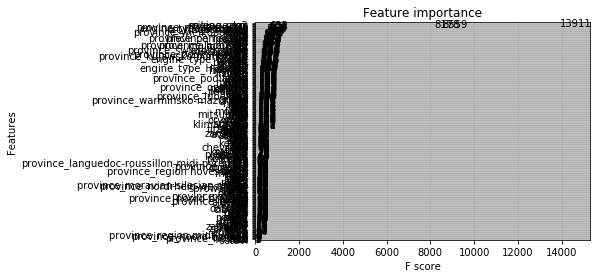

In [20]:
xgb.plot_importance(bst)

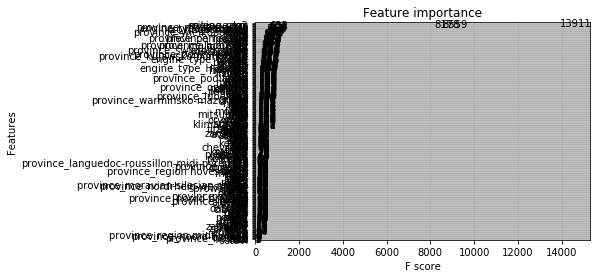

In [20]:
xgb.plot_importance(bst)

In [119]:
print(c)

None


In [97]:
final[0]

[[], ['a', 2]]

In [73]:
for index, (element1, el2) in enumerate(zip(a, b)):
    print(el2)

2
3


In [57]:
type(d)

tuple

In [45]:
final

[[[], [0, ('a', 2)]], [1, ('b', 3)]]

In [33]:
c

[1, 2]

In [20]:
def func(a):
    if type(a) == np.ndarray:
        print('yes, correct')
    else:
        return
    print('function quited')

In [28]:
np.array([])

array([], dtype=float64)

In [3]:
b = 'a'

In [48]:
b

int